In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Perceptron and Binary Classification

### **1. Learning Goals for This Notebook**

By the end of this lesson, we’ll be able to:

- Understand the basic structure of a **perceptron**, the building block of neural networks  
- Implement a **binary classifier** from scratch using the **perceptron update rule**  
- Visualize how decision boundaries evolve over training  
- Appreciate **why linear models can fail** on some classification problems  
- Prepare for deeper models by understanding **limitations of linear separability**

**What’s the Setup?**

We’ll work with a **simplified version** of the Heart Disease dataset.

To keep things intuitive, we’ll:
- Use only **2 input features** (so we can plot in 2D)
- Turn the output into a **binary classification task** (presence vs. absence of disease)

This lets us **see and understand** how the perceptron learns — step by step.

**Why This Matters**

Before we build complex neural networks, we need to understand:

- How does **a single neuron** make a decision?
- What does learning look like **in weight space**?
- When does a model **succeed or fail** — and why?

This notebook sets that foundation.

We will:

- Build a conceptual understanding of the **perceptron**  
- Manually implement the **perceptron update rule**  
- Visualize **classification boundaries** and how they change  
- Use both **NumPy and PyTorch** to get familiar with both styles  
- Reflect on where this model **breaks down** — and what to do next

---

### **2. Can a Line Classify?**

Before we jump into real medical data, let's first understand:

> **What does it mean for data to be linearly separable?**

**A Quick Reminder**

In **binary classification**, we want to learn a function that maps inputs $\mathbf{x}$ to a label $y \in \{0, 1\}$.

A dataset is **linearly separable** if:

> - There exists a **straight line** (or hyperplane) that **perfectly separates** the two classes.

**Let’s Build One!**

We’ll create a toy dataset with:
- 2D inputs (so we can **visualize** the data)
- Two distinct classes (0 and 1)
- Linearly separable distributions

**What We'll Do**

- Generate random 2D points for **class 0** and **class 1**
- Plot them using **matplotlib**
- Observe whether a line could separate them

**Expected Outcome**

You’ll see a 2D scatter plot like this:

![image-3.png](attachment:image-3.png)


Yes — a single line can separate them. That’s **linear separability**.

**Let’s try to create it!**

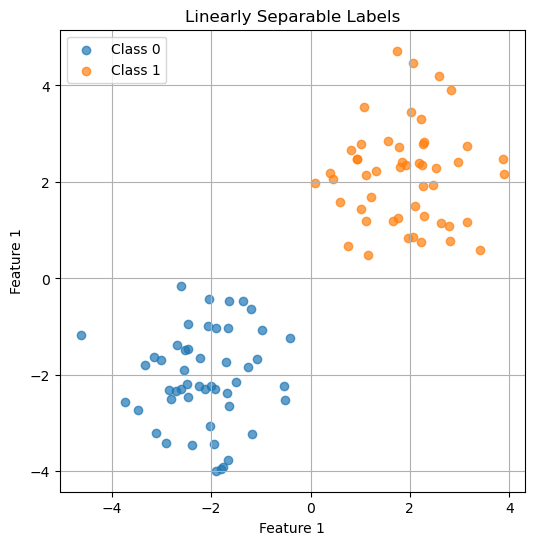

In [2]:
# set for reproducibility
np.random.seed(42)

class0 = np.random.randn(50, 2) + np.array([-2, -2]) # shifted to the lower bottom

class1 = np.random.randn(50, 2) + np.array([2, 2]) # shifted to the upper top

# stack into full dataset
X = np.vstack((class0, class1))
y = np.array([0] * 50 + [1] * 50)

# visualize
plt.figure(figsize=(6,6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='Class 1', alpha=0.7)

plt.xlabel('Feature 1')
plt.ylabel('Feature 1')
plt.title('Linearly Separable Labels')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

The two classes are clearly separable by a straight line.

A **linear model like a perceptron** can — in principle — learn to classify this data perfectly.

**Reflection Prompt:**
- Could you draw a line that separates these two classes? 
- What happens if the classes were closer? Or overlapping?
- Would a straight line still be enough?


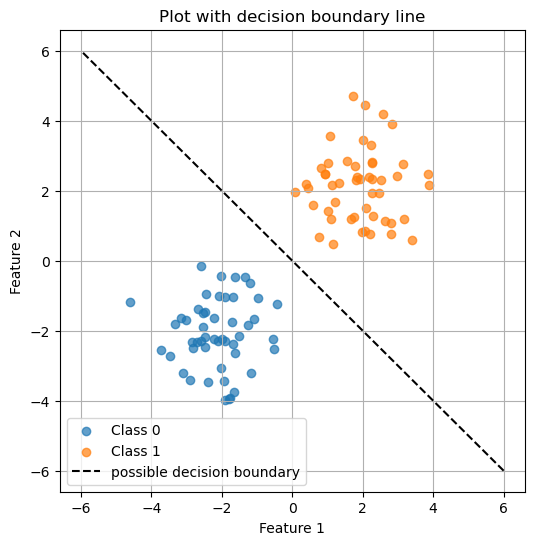

In [3]:
# same plot with candidate decision boundary line
plt.figure(figsize=(6,6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='Class 1', alpha=0.7)

x_line = np.linspace(6, -6, 100)
plt.plot(x_line, -x_line, '--k', label='possible decision boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plot with decision boundary line')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

### **3. The Perceptron — Intuition and Mathematics**



Now that we’ve created a toy dataset with two clearly separable classes, we’re ready to **introduce the perceptron** — one of the earliest models in neural networks.

> The perceptron is the simplest building block of a neural network.  
> It's a **binary classifier** that learns to separate two classes with a **straight line (or hyperplane)**.

**What Does a Perceptron Do?**

A perceptron takes **input features**, multiplies them with **weights**, adds a **bias**, and applies an **activation function** to decide the output (0 or 1).

**Perceptron Equation**

The perceptron computes:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

Then applies the step activation function:

$$
\hat{y} = 
\begin{cases}
1 & \text{if } z \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

Where:

- $\mathbf{x} \in \mathbb{R}^2$ is the **input vector** (e.g., `[feature1, feature2]`)  
- $\mathbf{w} \in \mathbb{R}^2$ is the **weight vector**  
- $b$ is the **bias** (scalar)  
- $\hat{y}$ is the **predicted label** (typically 0 or 1)

```text
  x₁        x₂  
   │        │  
   ▼        ▼  
 [w₁]     [w₂]    →   Weighted sum: z = w₁·x₁ + w₂·x₂ + b  
   \        /  
    ▼      ▼  
  Add bias (b)  
        ↓  
Step Activation  
        ↓  
Output: ŷ ∈ {0,1}
```

**Key Intuition**

The perceptron is learning to find a **line** that best separates the two classes.

That line is defined by:

$$
\mathbf{w}^\top \mathbf{x} + b = 0
$$

This is the **decision boundary**.

- If a point lies **above** the line → Class 1
- If a point lies **below** the line → Class 0

**However,**

- The perceptron **can only learn linearly separable data**.
- If the data is not linearly separable, the perceptron will **not converge** — it will keep updating weights forever!

---

### **4. Implementing the Perceptron in NumPy**

Now that we’ve seen the perceptron’s **mathematical foundation**, let’s bring it to life by **coding it from scratch** using **NumPy**.

We’ll train the perceptron using the **perceptron update rule** to separate our two toy classes.

**Perceptron Learning Algorithm**

Here’s how the training works:

For each training sample $(\mathbf{x}_i, y_i)$:

1. **Compute prediction** $\hat{y}_i$:

$$
\hat{y}_i = 
\begin{cases}
1 & \text{if } \mathbf{w}^\top \mathbf{x}_i + b \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

2. **Update weights and bias only if the prediction is wrong:**

- If $y_i = 1$ and $\hat{y}_i = 0$:

  $$
  \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \mathbf{x}_i
  $$

  $$
  b \leftarrow b + \eta
  $$

- If $y_i = 0$ and $\hat{y}_i = 1$:

  $$
  \mathbf{w} \leftarrow \mathbf{w} - \eta \cdot \mathbf{x}_i
  $$

  $$
  b \leftarrow b - \eta
  $$

Here, $\eta$ is the **learning rate** (e.g., 0.1)

**Step-by-Step Breakdown**

We will:

- Initialize weights $\mathbf{w}$ and bias $b$  
- Loop over the dataset for multiple epochs  
- Apply the update rule if prediction is incorrect  
- Track errors during training




**Perceptron from Scratch in NumPy**

In [4]:
n_feats = X.shape[1] # number of features
w = np.zeros(n_feats) # initial weight is zero for all features
b = 4.0 # intial bias

epochs = 5
lr = 0.1
errors_per_epoch = []

def step(z):
    return 1 if z >= 0 else 0

for epoch in range(epochs):
    total_error = 0
    for xi, yi in zip(X, y):
        z = np.dot(w , xi) + b
        y_hat = step(z)
        error = yi - y_hat
        if error != 0:
            w += lr * error * xi
            b += lr * error
            total_error += 1
    errors_per_epoch.append(total_error)
    print(f"Epoch {epoch+1}: errors = {total_error}")

Epoch 1: errors = 10
Epoch 2: errors = 2
Epoch 3: errors = 1
Epoch 4: errors = 0
Epoch 5: errors = 0


**What’s Going On?**

- We manually apply the **perceptron learning rule**  
- Each time a prediction is wrong, we **nudge** $\mathbf{w}$ and $b$  
- This slowly pushes the **decision boundary** in the correct direction

**Let's Visualize Training Performance**

We’ll now **plot how many errors** occurred in each epoch to see whether training is improving over time.

**Plot Training Errors Over Epochs**

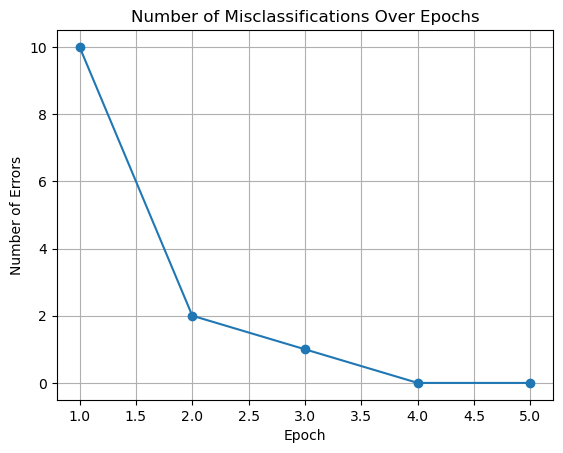

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), errors_per_epoch, marker='o')
plt.title('Number of Misclassifications Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Number of Errors')
plt.grid(True)
plt.show()

### 🔧 Code Task 2.1.4.1: Implement the Perceptron Prediction Step

**Your Task:**  
Write code that performs one prediction step using a perceptron with given weights, bias, and a batch of 3 input vector (given by the code below)

The perceptron uses the **step activation function**, where:

- Output is `1` if the input ≥ 0  
- Output is `0` otherwise

In [6]:
# Inputs (3 samples, 2 features each)
X_t = np.array([
    [1, 2],
    [-1, -2],
    [0, 1]
])

# Fixed weights and bias
w = np.array([1.0, -1.0])
b = 0.5

# TODO: Compute predictions using z = X_t @ w + b, then apply step function
# Store the result in a variable called `y_pred`
z = X_t @ w + b
y_pred = np.array([step(x) for x in z])


---

### **5. Visualizing the Decision Boundary**

Now that we’ve successfully trained our perceptron, let’s **visualize what the learned model is actually doing** in terms of decision making.


**🔍 What Are We Plotting?**

We want to plot the **decision boundary** learned by the perceptron,  
which is defined by the equation:

$$
\mathbf{w}^\top \mathbf{x} + b = 0
$$

For 2D input $\mathbf{x} = [x_1, x_2]$, this becomes:

$$
w_1 x_1 + w_2 x_2 + b = 0
$$

Solving for $x_2$:

$$
x_2 = \frac{ - (w_1 x_1 + b) }{ w_2 }
$$

or, equivalently:

$$
x_2 = \frac{ -b \pm w_1 x_1 }{ w_2 }
$$

> 🧭 **Why the ±?**  
>
> Depending on how the model converges, the sign of $w_1$ may be positive or negative.  
> Both forms describe the **same decision boundary** — just with flipped class sides.  
>
> ✅ We choose the form that produces a correctly placed line based on the learned weights and bias.


**Plot Decision Boundary**

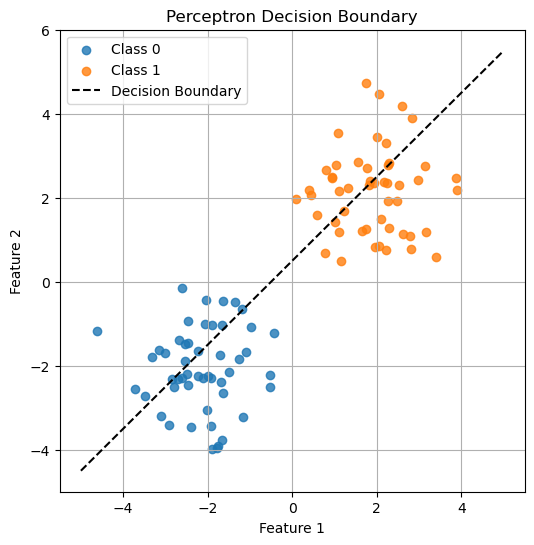

In [7]:
# Use the learned weights and bias from Section 4
w1, w2 = w[0], w[1]

# Create range of x1 values
x1_vals = np.linspace(-5, 5, 100)

# Compute corresponding x2 values from decision boundary equation
x2_vals = -(w1 * x1_vals + b) / w2

# Plot original data
plt.figure(figsize=(6,6))
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', alpha=0.8)
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', alpha=0.8)

# Plot the decision boundary line
plt.plot(x1_vals, x2_vals, color='black', linestyle='--', label='Decision Boundary')

plt.title("Perceptron Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

**Interpretation**

- Points **above the line** are classified as **Class 1**
- Points **below the line** are classified as **Class 0**
- The boundary is straight — as expected from a linear model

➡️ In the next section, we’ll see what happens when we use **real data** like Heart Disease — where not everything is linearly separable.

---

### **6. Preparing Heart Disease Dataset for Binary Classification**

Now that we’ve learned how a perceptron works on a clean toy dataset, let’s try using a **real-world dataset**: the **Heart Disease dataset**.

**Dataset Context**

This dataset contains medical features such as:
- Age, sex, cholesterol level, resting blood pressure, etc.
- A target column `num` representing **heart disease presence**

**Binary Setup**

To make this a **binary classification task**:

- We'll convert the target `num` to binary:
  - `0` → No heart disease
  - `1, 2, 3, 4` → Has heart disease → **set to 1**

This gives us a clear binary **(0 vs 1)** classification scenario.

**Feature Selection**

To mimic our toy example:

- We'll select **just two features** to visualize decision boundaries
- Let’s use:
  - `thalach` → maximum heart rate achieved
  - `oldpeak` → ST depression induced by exercise

These are commonly used indicators in heart disease studies and form a good 2D space for plotting.


**Load and Simplify the Dataset**

In [8]:
data = pd.read_csv('heart.csv')

data.dropna(inplace=True)
X_real = data[['thalach', 'oldpeak']].values
y_real = data['target'].values


print('X_real Shape', X_real.shape)
print('y_real class distribution:', np.bincount(y_real))

X_real Shape (303, 2)
y_real class distribution: [138 165]


**Why Just Two Features?**

To **visualize decision boundaries**, we need data in **2D** — hence, just two features for now.

In future notebooks, we’ll explore **multi-feature** setups using full networks.

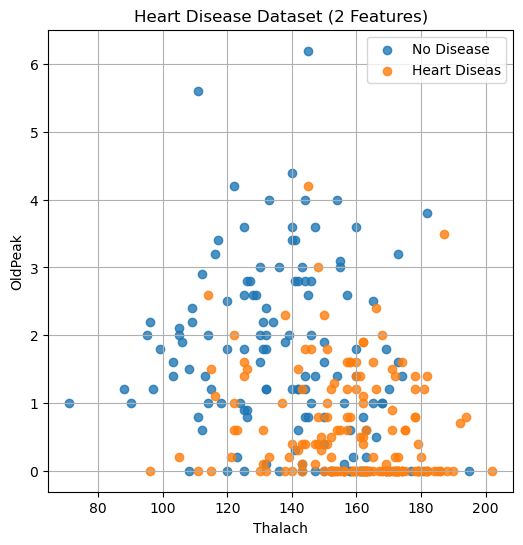

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(X_real[y_real == 0, 0], X_real[y_real == 0, 1], label='No Disease', alpha=0.8)
plt.scatter(X_real[y_real == 1, 0], X_real[y_real == 1, 1], label='Heart Diseas', alpha=0.8)
plt.xlabel('Thalach')
plt.ylabel('OldPeak')
plt.title("Heart Disease Dataset (2 Features)")
plt.legend()
plt.grid(True)
plt.show()

**What Should You Notice?**

- The real data is **less clean and more overlapping** than the toy dataset
- We’ll now see how well the **perceptron handles real-world non-linearity**

We’ll apply our NumPy perceptron on this real data — and observe where it fails.

---

### **7. Training a Perceptron on Real Data (NumPy)**

Now that we’ve prepped the real-world heart disease data, let’s apply our **NumPy perceptron** to this dataset and observe how it performs.

**Perceptron on Real Data: Expectations**

Unlike our clean toy dataset, this dataset:

- Is **noisy** and **partially overlapping**
- Will likely **not** be perfectly separable with a straight line
- Will be helpful to understand a lot about the **limits** of linear models

**Perceptron Training on Real Dataset**

In [10]:
w_real = np.random.randn(X_real.shape[1])
b_real = np.random.randn()

epochs = 50
lr = 0.1
errors_real = []

# define step
def step(z): return 1 if z >= 0 else 0

for epoch in range(epochs):
    total_errors = 0
    for xi, yi in zip(X_real, y_real):
        z = np.dot(w_real, xi) + b_real
        y_hat = step(z)

        error = yi - y_hat
        if error != 0:
            w_real += lr * error * xi
            b_real += lr * error
            total_errors += 1
    errors_real.append(total_error)
print("Final weights:", w_real)
print("Final bias:", b_real)

Final weights: [-11.04221264   0.17078453]
Final bias: -0.6169487568247228


**Let’s Plot the Training Errors**

Just like before, we’ll track whether training is reducing errors.

**Plot Errors Over Epochs**

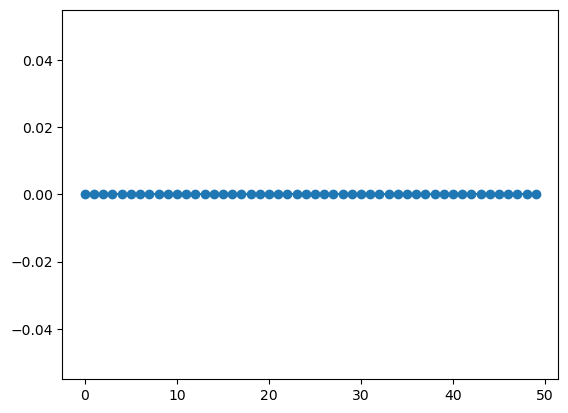

In [12]:
plt.plot(range(epochs), errors_real, marker = 'o')

**What to Expect**

Even after many epochs, we’ll likely **still see errors** — that’s okay!

- That’s because **real data is noisy**  
- And a **straight line** can’t always separate everything

➡️ In the next section, we’ll plot the decision boundary to **see this visually**.

---

### 🔧 Code Task 2.1.7.1: Evaluate Your Trained Perceptron

Use your final trained weights and bias (`w_real`, `b_real`) to make predictions on the full dataset and compute the classification **accuracy**.

**Instructions:**

- Loop through each input sample in `X_real`.
- For each sample:
  - Compute the dot product plus bias:  
    `z = np.dot(w_real, xi) + b_real`
  - Apply the step function:
    - Output `1` if `z >= 0`
    - Output `0` otherwise
- Compare predictions to the true labels in `y_real`.
- Count how many predictions are correct.
- Compute the final accuracy as:  
  `expected_accuracy = correct_predictions / total_predictions`

**Expected Output:**  
A float between `0` and `1`, stored in a variable named `expected_accuracy`.

In [13]:
w_real.shape, X_real.shape

((2,), (303, 2))

In [14]:
def accuracy(X_real):
    return np.dot(X_real, w_real) + b_real

z = accuracy(X_real)
y_preds = np.array([step(x) for x in z])

correct_preds = y_real == y_preds

expected_accuracy = np.mean(correct_preds)
print(f"✅ Expected Accuracy: {expected_accuracy:.2f}")

✅ Expected Accuracy: 0.46


### **8. Visualizing the Decision Boundary on Real Data**

We’ve trained our perceptron on real patient data.  
Now it’s time to **visualize the decision boundary**.

This helps us answer:

> “Where is the model drawing the line between ‘disease’ and ‘no disease’?”

**What We Expect:**

- The model learned a **line** in the 2D feature space
- But it will likely **not cleanly separate** the classes (due to overlap)

### **Reminder: How to Plot the Decision Line**

We learned a decision rule:

$$
\hat{y} = 
\begin{cases}
1 & \text{if } \mathbf{w}^\top \mathbf{x} + b \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

This means the **decision boundary** is where:

$$
\mathbf{w}^\top \mathbf{x} + b = 0
$$

Solving for $x_2$ (vertical axis):

$$
x_2 = \frac{-b \pm w_1 x_1}{w_2}
$$

> ⚠️ **Why the ±?**
>
> Depending on how the perceptron learns the weights, we may end up with either:
>
> - $x_2 = \frac{-b - w_1 x_1}{w_2}$
> - $x_2 = \frac{-b + w_1 x_1}{w_2}$
>
> These are mathematically equivalent in terms of the line’s location — they just flip which side is classified as 1 vs. 0.
>
> ✅ **In practice:** We use the version that matches the learned weights so that the line appears correctly in the plot.


**Plot Decision Boundary**

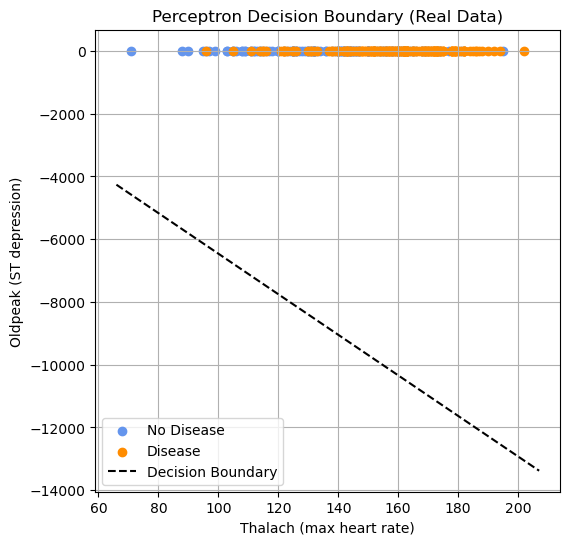

In [15]:
# Extract weights and bias from trained model
w1, w2 = w_real[0], w_real[1]
b = b_real

# Set up line for decision boundary
x1_vals = np.linspace(X_real[:, 0].min() - 5, X_real[:, 0].max() + 5, 100)
x2_vals = (-b + w1 * x1_vals) / w2

# Plot data points again
plt.figure(figsize=(6,6))
plt.scatter(X_real[y_real==0][:, 0], X_real[y_real==0][:, 1], color='cornflowerblue', label='No Disease')
plt.scatter(X_real[y_real==1][:, 0], X_real[y_real==1][:, 1], color='darkorange', label='Disease')

# Plot the decision boundary
plt.plot(x1_vals, x2_vals, color='black', linestyle='--', label='Decision Boundary')

plt.xlabel('Thalach (max heart rate)')
plt.ylabel('Oldpeak (ST depression)')
plt.title('Perceptron Decision Boundary (Real Data)')
plt.legend()
plt.grid(True)
plt.show()

**Reflection Prompt (implicit)**

- How well does this line separate the two classes?
- Are there many points on the wrong side?
- What would help improve this?

➡️ In the final section, we’ll reflect on these questions and preview what comes next!

### **9. Final Reflection and What’s Next**

**What We Built**

In this notebook, we:

- Introduced the **perceptron** — the most basic building block of neural networks.
- Learned its **mathematical structure** and **decision rule**.
- Implemented it from scratch using **NumPy**.
- Visualized its training and **decision boundaries** on:
  - A **toy dataset** (linearly separable ✅)
  - A **real dataset** (heart disease, not fully separable ❌)

**What We Observed**

- The perceptron **works well** when data is **linearly separable**.
- But with **real-world data**, its ability to find good decision boundaries is **limited**.

**What This Tells Us**

- **Linear models** are useful but limited.
- **Non-linear decision boundaries** are often needed.
- To achieve that, we must go beyond a single neuron.

**What’s Coming in NB02**

In the next notebook, we will:

- Introduce the **Multi-Layer Perceptron (MLP)**.
- Add **hidden layers** and **activation functions**.
- See how **non-linearity** helps the model learn more complex relationships.
- Apply MLPs to the same heart disease dataset and compare performance.

**Why it matters:**  
The perceptron was just the beginning.  
Now we’re ready to build **networks of neurons** that can learn **deeper** and **richer** patterns in data.
